In [20]:
#Zaimportowanie wymaganych bibliotek
import os
import numpy as np
from pathlib import Path
from keras.layers import Input, Reshape, Dropout, Dense, Flatten, BatchNormalization, Activation, ZeroPadding2D, LeakyReLU, Conv2DTranspose
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.metrics import Mean
from numpy import zeros,ones,vstack
from numpy.random import randn,randint,normal
from numpy.random import default_rng
from IPython.display import clear_output
from math import trunc

from matplotlib import pyplot

from PIL import Image


In [21]:
#Parametry
VERSION=0.3
#PATH_TO_DATA='data/cubism_data_norm.npy'
#DATA="cubism"
PATH_TO_DATA='data/delaunay_data_norm.npy'
DATA="delaunay"

#Number of saved images during training
OUTPUT = 8
OUTPUT_MARGIN = 4
SAVE_FREQ = 100 #How often to save images
OUTPUT_PATH='output\\new'
'''
In this use case, our latent space representations are used to
transform more complex forms of raw data (i.e. images, video),
into simpler representations which are "more convenient to process" and analyze.
'''
NOISE_SIZE = 128#Lantent dimention size

EPOCHS = 5000 #Iterations 100000 the biger, the longer the model will train
BATCH_SIZE = 64 #number of images in the Batch. Larger Batch → Weak Generalization, Larger Batches → Fewer updates + shifting data → lower computational costs

#
#cross_entropy=BinaryCrossentropy()
mean=Mean()

In [22]:
train_data = np.load(PATH_TO_DATA)
print("(number of images,size_x,size_y,color_channels)")
print(train_data.shape)
if train_data.shape[1]!=train_data.shape[2]:
    print("Something is wrong")

(number of images,size_x,size_y,color_channels)
(11503, 64, 64, 3)


In [23]:
#size of images
IMG_SIZE = train_data.shape[1] #rows/cols
IMG_CHANNELS = train_data.shape[3] #color channels in our images

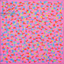

In [24]:
Image.fromarray(((train_data[1]+1)*255/2).astype(np.uint8))

In [25]:
#discriminator
def build_discriminator(image_shape):
    model = Sequential(name="Discriminator")
        
    #model.add(Conv2D(32, kernel_size=4, strides=2,input_shape=image_shape,data_format="channels_last",padding="same"))
    #model.add(BatchNormalization(axis=1,momentum=0.8))
    #model.add(LeakyReLU(alpha=0.2))
    #model.add(Dropout(0.25))#dropout layer to prevent overfitting    
    
    model.add(Conv2D (64, kernel_size=4, strides=2, padding="same",input_shape=image_shape,data_format="channels_last"))
    #model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.20))    

    model.add(Conv2D(128, kernel_size=4, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.20))    
    
    model.add(Conv2D(256, kernel_size=4, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))    
    model.add(Dropout(0.20))
    
    model.add(Conv2D(256, kernel_size=4, strides=1, padding="valid"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))    
    model.add(Dropout(0.20))
    
    model.add(Flatten())
    model.add(Dense(1, activation="sigmoid"))#binary clasification

    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss=binary_crossentropy,optimizer=opt,metrics=['accuracy'])
    model.summary()
    
    return model

In [26]:
#generator
def build_generator(noise_size, channels):
     model = Sequential(name="Generator")
     model.add(Dense(1 * 1 * 128, activation="relu",input_dim=noise_size))
     model.add(Reshape((1, 1, 128)))    
     model.add(Conv2DTranspose(512,kernel_size=4, strides=1, padding="valid"))
     model.add(BatchNormalization(momentum=0.8))
     model.add(Activation("relu"))    
               
     #model.add(UpSampling2D())
     #model.add(Conv2D(256, kernel_size=4, padding="same"))
     model.add(Conv2DTranspose(256,kernel_size=4, strides=2, padding="same"))
     model.add(BatchNormalization(momentum=0.8))
     model.add(Activation("relu"))    

     #model.add(UpSampling2D())
     #model.add(Conv2D(256, kernel_size=4, padding="same"))
     model.add(Conv2DTranspose(128,kernel_size=4, strides=2, padding="same"))
     model.add(BatchNormalization(momentum=0.8))
     model.add(Activation("relu"))
     
     model.add(Conv2DTranspose(64,kernel_size=4, strides=2, padding="same"))
     model.add(BatchNormalization(momentum=0.8))
     model.add(Activation("relu"))        
          
     model.add(Conv2DTranspose(channels, kernel_size=4,strides=2, padding="same"))
     model.add(Activation("tanh"))    

     model.summary()

     return model

In [27]:
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential(name="GAN")
    model.add(generator)
    model.add(discriminator)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    model.summary()
    return model

In [28]:
def save_images(generator,noise,number):
    generated_images = generator.predict(noise)
    print(generated_images)
    #from (-1,1) to (0,255)
    generated_images = (generated_images+1)*255/2
    if not os.path.exists(OUTPUT_PATH):
        os.makedirs(OUTPUT_PATH)
    filename = os.path.join(OUTPUT_PATH, DATA+"-%d.png"%(number))
    im = Image.fromarray(generated_images)
    im.save(filename)

In [29]:
def get_real_samples(data, n_samples):
    indexes = randint(0, data.shape[0], n_samples)
    X = data[indexes]
    y = ones((n_samples, 1))
    return X, y

def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = default_rng().normal(0.0, 1.0, (n_samples, latent_dim))
    X = generator.predict(x_input)
    y = zeros((n_samples, 1))
    return X, y


In [30]:
def summarize_performance(epoch, generator, discriminator, dataset, latent_dim, n_samples=100):
    #getting samples and evaluating
    X_real, y_real = get_real_samples(dataset, n_samples)
    _, acc_real = discriminator.evaluate(X_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n_samples)
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    print('Accuracy on real: %.0f%%, on fake: %.0f%%' % (acc_real*100, acc_fake*100))
    filename = 'gen_model_v_%.1f_e_%d.h5' % (VERSION,epoch + 1)
    generator.save('models\\'+filename,include_optimizer=True)
    return acc_real,acc_fake

In [31]:
def train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=100, n_batch=10):
    batchs_per_epoch = int(dataset.shape[0] / n_batch)
    half_of_batch=int(int(n_batch / 2))
    #generating fixed noise for examples images
    fixed_noise = default_rng().normal(loc=0.0, scale=1.0, size=(OUTPUT * OUTPUT, latent_dim))
    number=1
    perfect_rounds=0
    i=0
    work=True
    while i <= n_epochs and work:
        for j in range(batchs_per_epoch):
            #geting and generating samples
            X_real, y_real = get_real_samples(dataset, half_of_batch)
            X_fake, y_fake = generate_fake_samples(generator, latent_dim, half_of_batch)
            #joining the real images with false ones
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            X_gan = default_rng().normal(0.0, 1.0, (n_batch,latent_dim))
            y_gan = ones((n_batch, 1))
            #training
            d_loss,_ = discriminator.train_on_batch(X, y)
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print('Epoch:%d, Batch:%d/%d, d_loss=%.4f, g_loss=%.4f' % (i+1, j+1, batchs_per_epoch, d_loss, g_loss))
        if (i+1) % 10 == 0:
            #saving images based on fixed noise
            save_images(generator, fixed_noise, number)
            number+=1
            clear_output()
            #getting accuracy
            acc_real,acc_fake=summarize_performance(i, generator, discriminator, dataset, latent_dim)
            #if both accuraccies is 100% for 5 epochs, than end program
            if round(acc_real,2)==100.00 and round(acc_fake,2)==100.00:
                perfect_rounds+=1
            else:
                perfect_rounds=0
            if(perfect_rounds==5):
                work=False
            

In [32]:
image_shape = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
discriminator = build_discriminator(image_shape)
generator = build_generator(NOISE_SIZE, IMG_CHANNELS)

gan_model = build_gan(generator, discriminator)
#print(train_data.shape)
train(generator, discriminator, gan_model, np.array(train_data), NOISE_SIZE,EPOCHS)
#print(train_data)

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                     

In [ ]:
def get_gen_model(filename=""):
    generator
    if(filename!=""):
        generator=load_model("models\\"+filename,compile=False)
    return generator

model = get_gen_model()
latent_points = default_rng().normal(0.0, 1.0, (NOISE_SIZE, 1))
X = model.predict(latent_points)
#array = np.array(((0.5*X.reshape(64,64,3)+1)*255).astype(np.uint8))
array = np.array(((X.reshape(64,64,3)+1)*255/2).astype(np.uint8))

image = Image.fromarray(array)
image.show()
#image.save("output\\a1.png")